In [177]:
# OPERATIONAL PACKAGES ---------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import inf
import scipy as sp

# STYLE RESOURCES ---------------------------------------
plt.style.reload_library()
plt.style.use(['science', 'grid'])

# FITTING PACKAGES ---------------------------------------
from lmfit import Model, Parameters

In [288]:
# DEFINING A FUNCTION THAT CLEANS THE DATA USING PETER'S NICE CODE ---------------------------------------
def CLEAN_INPUT(file):
    # cleaning superconductor data
    data = []
    clean_data = []

    # extract raw data
    f = open(file, 'r')
    for line in f:
        data.append(line)
    f.close()

    for i in range(0, len(data)):
        # broken apart by spaces
        temp = data[i].split(' ')
        if len(temp) == 3:
            clean_data.append(temp)
            # gets rid of newline in str
            clean_data[-1][-1] = clean_data[-1][-1].replace('\n','')

    # convert str to flt
    clean_data = np.array(clean_data, dtype = float)
    return clean_data

# FUNCTION FOR PLOTTING A SCATTER PLOT ---------------------------------------
def ScatterPlot(xdata,ydata,error_x,error_y,color,x_label,y_label):
    
    # SCATTER PLOT
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.errorbar(xdata,ydata,yerr=error_y,capsize = 5,marker = 'o',markersize=1, linestyle = 'None',color='black')
    plt.errorbar(xdata,ydata,xerr=error_x,capsize = 5,marker = 'o',markersize=1, linestyle = 'None',color='black')
    
    title = r'$\textbf{' + y_label + ' vs ' + x_label + '}$'
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("Figures/figure.png")
    
# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD ---------------------------------------
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

# DEFINING A FUNCTION THAT CALCULATES THE RESISTANCE HAVING VOLTAGE AND CURRENT AS INPUTS ---------------------------------------
calculate_R = lambda param : abs(param[0]/param[1]) # param = [V, I]

# DEFINING THE SIGMOID FUNCTION ---------------------------------------
Sigmoid = lambda x, L ,x0, k : L/(1 + np.exp(-k*(x-x0))) 
# L: Height, k: steepness, x0: center

def FUNCTION_FIT(xdata, ydata, error_x, error_y, color, x_label, y_label, function):
    
    # Plotting scatter plot first
    ScatterPlot(xdata,ydata,error_x,error_y,color,x_label,y_label)
    
    # Fitting data using LMFIT
    gModel = Model(function)
    L ,x0, k = ydata.max(), np.median(xdata), 1 # Initial guess
    gModel.set_param_hint('L', value=L, min=0, max=inf)
    gModel.set_param_hint('x0', value=x0, min=0, max=inf)
    gModel.set_param_hint('k', value=k, min=0, max=inf)
    params = gModel.make_params()
    result = gModel.fit(ydata, x=xdata, L=L, x0=x0, k=k, weights=1/error_y)
    
    # Plotting Fitted Function
    L ,x0, k = result.params['L'].value, result.params['x0'].value, result.params['k'].value
    dx0 = result.params['x0'].stderr
    label = r'$\textit{(' + str("{:.5}".format(x0)) + '±' + str("{:.2}".format(dx0)) + ') K}$'
    #plt.plot(xdata,result.best_fit, color=color)
    x = np.arange(xdata.min(), xdata.max(), (xdata.max()-xdata.min())/1000) 
    plt.plot(x, function(x, L ,x0, k), color=color)
        
    #VERTICAL LINE 
    plt.axvline(x=x0, color='k', linestyle='--', label=label)
    plt.legend(prop={'size': 12}, loc=2)
    plt.savefig("Figures/figure.png")
    plt.show()
    
    # CALCULATING THE P-VALUE
    print('Corresponding p-value:',1.000-sp.stats.chi2.cdf(result.chisqr,result.nfree))
    print('Degrees of freedom:',result.nfree)
    
    # FIRST DERIVATIVE
    print('FIRST DERIVATIVE')
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{First derivative}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    y_prime = np.gradient(function(x, L ,x0, k))
    #deltax_prime = uncertainty_var(function(x, L ,x0, k), error_y, Sigmoid_inverse_der1(function(x, L ,x0, k), L ,x0, k))
    #plt.errorbar(x,y_prime,xerr=deltax_prime,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.plot(x, y_prime, color=color)
    plt.savefig("Figures/figure2.png")
    plt.show()
    
    # SECOND DERIVATIVE
    print('SECOND DERIVATIVE')
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{Second derivative}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    y_2prime = np.gradient(y_prime)
    plt.plot(x, y_2prime, color=color)
    
    # MAX RATE OF CHANGE
    x0 = x[np.where(y_2prime == y_2prime.max())][0]
    label = r'$\textit{(' + str("{:.5}".format(x0)) + '±' + str("{:.2}".format(dx0)) + ') K}$'
    plt.axvline(x=x0, color='k', linestyle='--', label=label)
    plt.legend(prop={'size': 12}, loc=3)
    plt.savefig("Figures/figure3.png")
    plt.show()

    return result, [x0, dx0]   

In [344]:
# DEFINING RESULTS ARRAY
temperatures = []

***
### <font color=green>BUCKET 1 (WITH SUPERCONDUCTOR)</font>
***

# COOLING 1

In [323]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_Cooling1.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = df['Voltage (mV)']/df['I (mA)']
df = df[(df['Resistance ($\Omega$)']<1.25e-2) | (df['Resistance ($\Omega$)']>1.49e-2)] # Adjusting vertical range to fit data

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,100.073241,1.833901,215.157236,0.018326,0.01,0.01,0.01,0.0001
1,100.069459,1.834235,215.181621,0.018330,0.01,0.01,0.01,0.0001
2,100.069377,1.834668,215.202756,0.018334,0.01,0.01,0.01,0.0001
3,100.064778,1.834620,215.173287,0.018334,0.01,0.01,0.01,0.0001
4,100.068116,1.834379,215.076589,0.018331,0.01,0.01,0.01,0.0001


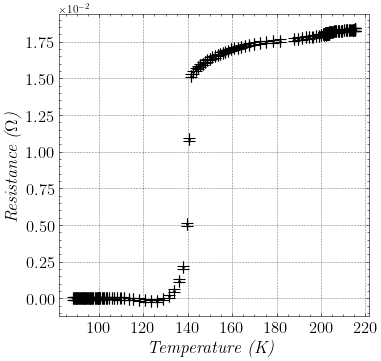

In [324]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')

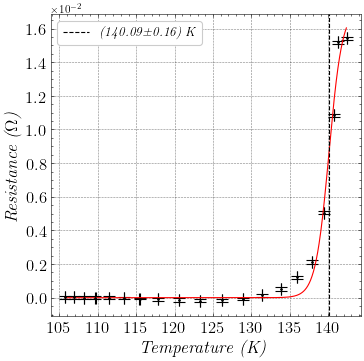

Corresponding p-value: 0.0
Degrees of freedom: 17
FIRST DERIVATIVE


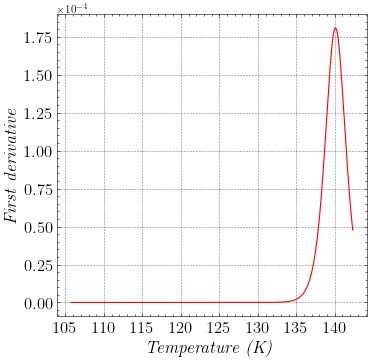

SECOND DERIVATIVE


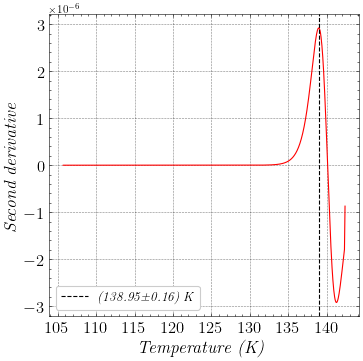

In [325]:
# FITTING OUR FUNCTION
x_min, x_max = 105, 143
df_study = df[(df['Temperature (K)'] >= x_min) & (df['Temperature (K)'] <= x_max)]
xdata, ydata, error_x, error_y = df_study['Temperature (K)'], df_study['Resistance ($\Omega$)'], df_study['$\Delta$ T (K)'], df_study['$\Delta$ R ($\Omega$)']
results, tc_val = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', 'Temperature (K)', 'Resistance ($\Omega$)', Sigmoid)
temperatures.append(tc_val)
results

# WARMING 1

In [345]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_Warming1.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = np.abs(df['Voltage (mV)']*1e3)
df['Resistance ($\Omega$)'] = df['Voltage (mV)']/df['I (mA)']

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,100.058331,0.000505,83.353296,0.000005,0.01,0.01,0.01,0.000095
1,100.052682,0.000382,83.432066,0.000004,0.01,0.01,0.01,0.000096
2,100.058630,0.000986,83.513228,0.000010,0.01,0.01,0.01,0.000090
3,100.059577,0.000960,83.606945,0.000010,0.01,0.01,0.01,0.000090
4,100.056507,0.000666,83.741711,0.000007,0.01,0.01,0.01,0.000093


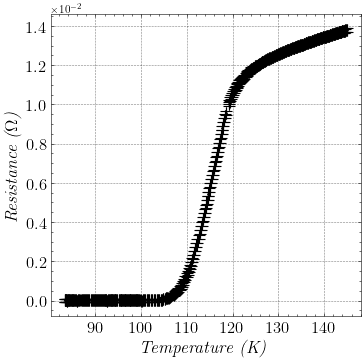

In [346]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')

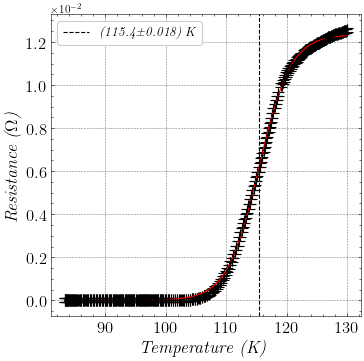

Corresponding p-value: 0.7845539849901287
Degrees of freedom: 218
FIRST DERIVATIVE


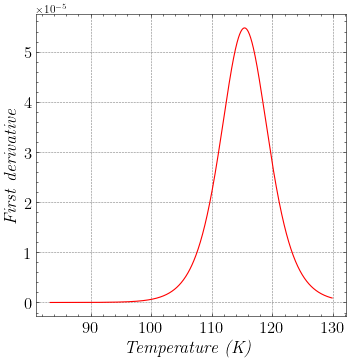

SECOND DERIVATIVE


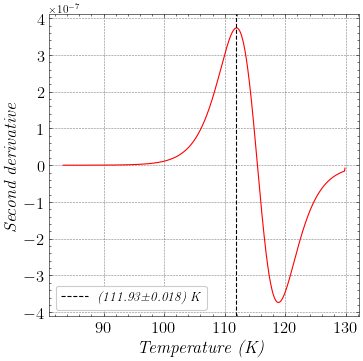

In [347]:
# FITTING OUR FUNCTION
x_min, x_max = 10, 130
df_study = df[(df['Temperature (K)'] >= x_min) & (df['Temperature (K)'] <= x_max)]
xdata, ydata, error_x, error_y = df_study['Temperature (K)'], df_study['Resistance ($\Omega$)'], df_study['$\Delta$ T (K)'], df_study['$\Delta$ R ($\Omega$)']
results, tc_val = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', 'Temperature (K)', 'Resistance ($\Omega$)', Sigmoid)
temperatures.append(tc_val)
results

# COOLING 2

In [329]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_Cooling2.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = np.abs(df['Voltage (mV)']/df['I (mA)'])

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,100.047285,1.388910,146.120115,0.013883,0.01,0.01,0.01,0.0001
1,100.049743,1.391290,146.208832,0.013906,0.01,0.01,0.01,0.0001
2,100.050312,1.391033,146.287117,0.013903,0.01,0.01,0.01,0.0001
3,100.054598,1.392116,146.342671,0.013914,0.01,0.01,0.01,0.0001
4,100.054230,1.393020,146.385849,0.013923,0.01,0.01,0.01,0.0001


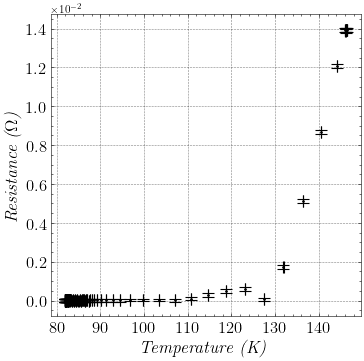

In [330]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')

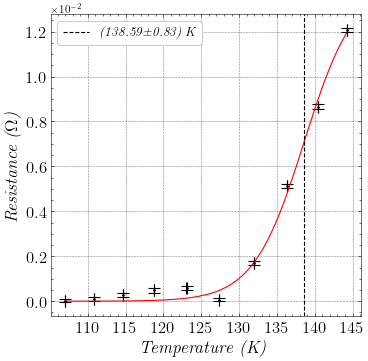

Corresponding p-value: 0.0
Degrees of freedom: 7
FIRST DERIVATIVE


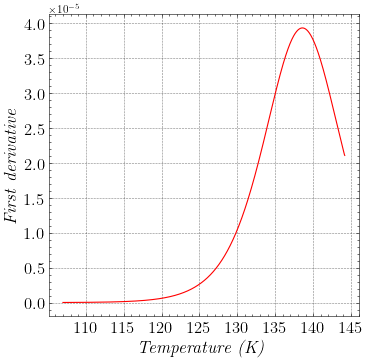

SECOND DERIVATIVE


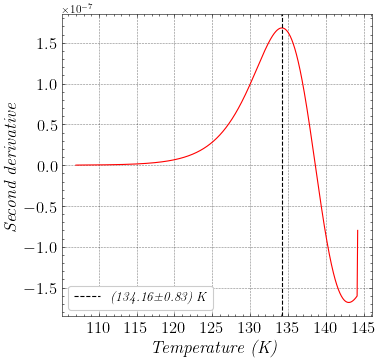

In [331]:
# FITTING OUR FUNCTION
x_min, x_max = 105, 145
df_study = df[(df['Temperature (K)'] >= x_min) & (df['Temperature (K)'] <= x_max)]
xdata, ydata, error_x, error_y = df_study['Temperature (K)'], df_study['Resistance ($\Omega$)'], df_study['$\Delta$ T (K)'], df_study['$\Delta$ R ($\Omega$)']
results, tc_val = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', 'Temperature (K)', 'Resistance ($\Omega$)', Sigmoid)
temperatures.append(tc_val)
results

# WARMING 2

In [348]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_Warming2.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = df['Voltage (mV)']/df['I (mA)']

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,100.063758,0.000313,83.934242,0.000003,0.01,0.01,0.01,0.000097
1,100.059550,0.001238,84.080253,0.000012,0.01,0.01,0.01,0.000088
2,100.063234,0.000126,84.228432,0.000001,0.01,0.01,0.01,0.000099
3,100.059992,0.000564,84.361092,0.000006,0.01,0.01,0.01,0.000094
4,100.063434,0.000789,84.527499,0.000008,0.01,0.01,0.01,0.000092


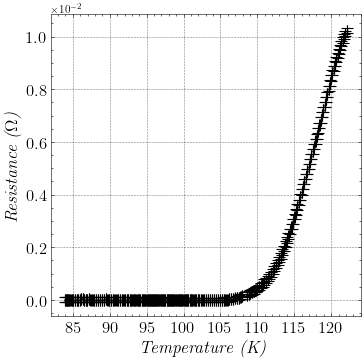

In [349]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')

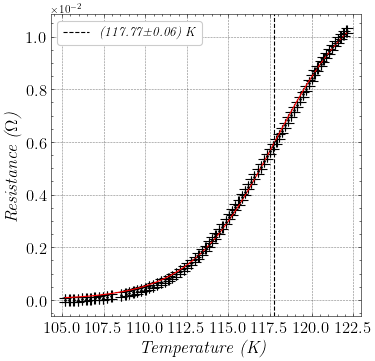

Corresponding p-value: 0.6129109438401161
Degrees of freedom: 78
FIRST DERIVATIVE


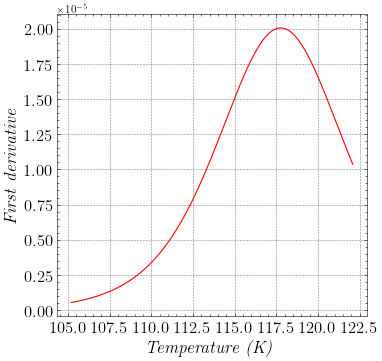

SECOND DERIVATIVE


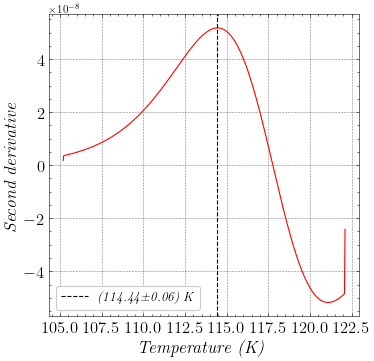

In [350]:
# FITTING OUR FUNCTION
x_min, x_max = 105, 125
df_study = df[(df['Temperature (K)'] >= x_min) & (df['Temperature (K)'] <= x_max)]
xdata, ydata, error_x, error_y = df_study['Temperature (K)'], df_study['Resistance ($\Omega$)'], df_study['$\Delta$ T (K)'], df_study['$\Delta$ R ($\Omega$)']
results, tc_val = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', 'Temperature (K)', 'Resistance ($\Omega$)', Sigmoid)
temperatures.append(tc_val)
results

# COOLING 3

In [269]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_Cooling3.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = np.abs(df['Voltage (mV)']/df['I (mA)'])

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,100.065905,1.135764,124.280172,0.011350,0.01,0.01,0.01,0.0001
1,100.067697,1.138462,124.407228,0.011377,0.01,0.01,0.01,0.0001
2,100.063756,1.131784,124.405161,0.011311,0.01,0.01,0.01,0.0001
3,100.064517,0.580916,123.761391,0.005805,0.01,0.01,0.01,0.0001
4,100.060299,0.047653,121.229469,0.000476,0.01,0.01,0.01,0.0001


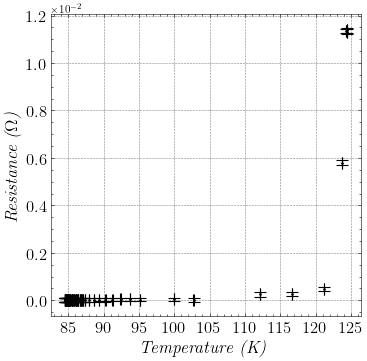

In [270]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')

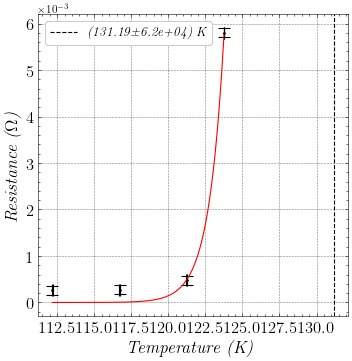

Corresponding p-value: 0.00018811941152607758
Degrees of freedom: 1
FIRST DERIVATIVE


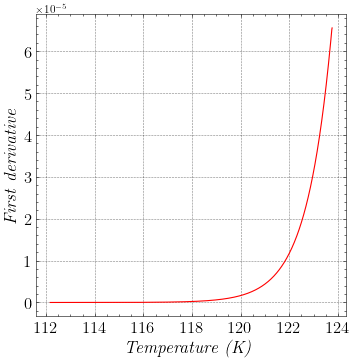

SECOND DERIVATIVE


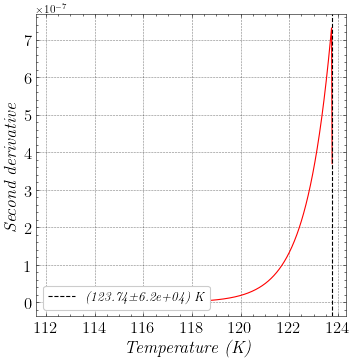

In [271]:
# FITTING OUR FUNCTION
x_min, x_max = 110, 124
df_study = df[(df['Temperature (K)'] >= x_min) & (df['Temperature (K)'] <= x_max)]
xdata, ydata, error_x, error_y = df_study['Temperature (K)'], df_study['Resistance ($\Omega$)'], df_study['$\Delta$ T (K)'], df_study['$\Delta$ R ($\Omega$)']
FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', 'Temperature (K)', 'Resistance ($\Omega$)', Sigmoid)

# WARMING 3

In [351]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_Warming3.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = df['Voltage (mV)']/df['I (mA)']

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,100.070206,0.001719,87.767164,0.000017,0.01,0.01,0.01,0.000083
1,100.071933,0.001649,87.974368,0.000016,0.01,0.01,0.01,0.000083
2,100.071694,0.002280,88.169867,0.000023,0.01,0.01,0.01,0.000077
3,100.071198,0.001360,88.367720,0.000014,0.01,0.01,0.01,0.000086
4,100.065245,0.000954,88.571287,0.000010,0.01,0.01,0.01,0.000090


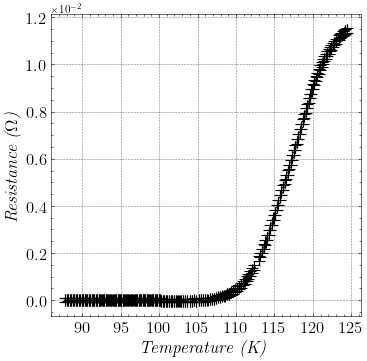

In [352]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')

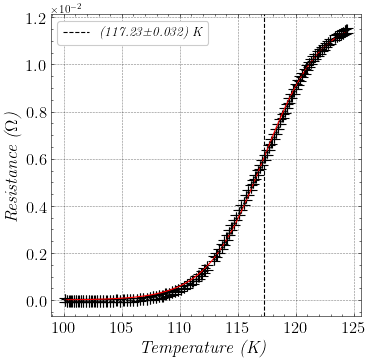

Corresponding p-value: 0.4379549827982727
Degrees of freedom: 105
FIRST DERIVATIVE


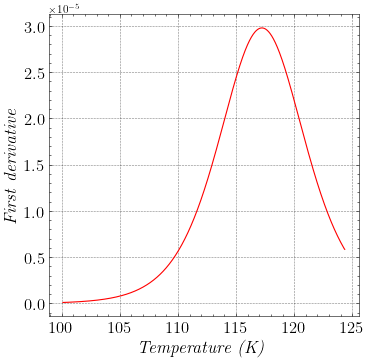

SECOND DERIVATIVE


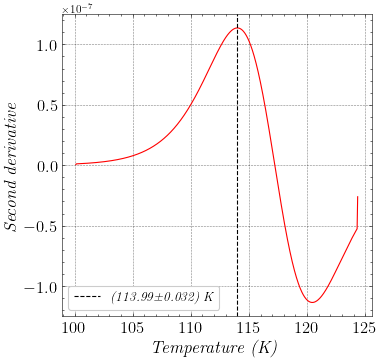

In [353]:
# FITTING OUR FUNCTION
x_min, x_max = 100, 125
df_study = df[(df['Temperature (K)'] >= x_min) & (df['Temperature (K)'] <= x_max)]
xdata, ydata, error_x, error_y = df_study['Temperature (K)'], df_study['Resistance ($\Omega$)'], df_study['$\Delta$ T (K)'], df_study['$\Delta$ R ($\Omega$)']
results, tc_val = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', 'Temperature (K)', 'Resistance ($\Omega$)', Sigmoid)
temperatures.append(tc_val)
results

# COOLING 4

In [272]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_Cooling4.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = np.abs(df['Voltage (mV)']/df['I (mA)'])

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,100.076987,1.201376,126.968849,0.012005,0.01,0.01,0.01,0.0001
1,100.074461,1.204492,127.112873,0.012036,0.01,0.01,0.01,0.0001
2,100.072488,1.067273,127.082670,0.010665,0.01,0.01,0.01,0.0001
3,100.077886,0.662859,125.465678,0.006623,0.01,0.01,0.01,0.0001
4,100.074009,0.115860,121.103460,0.001158,0.01,0.01,0.01,0.0001


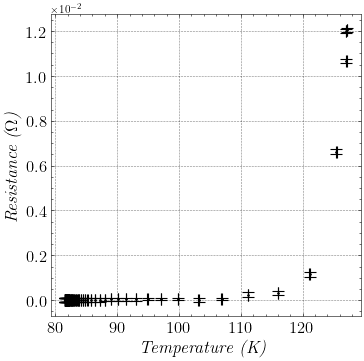

In [274]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')

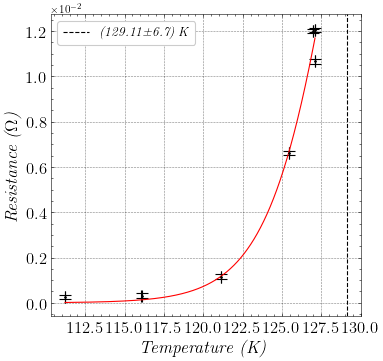

Corresponding p-value: 0.0
Degrees of freedom: 4
FIRST DERIVATIVE


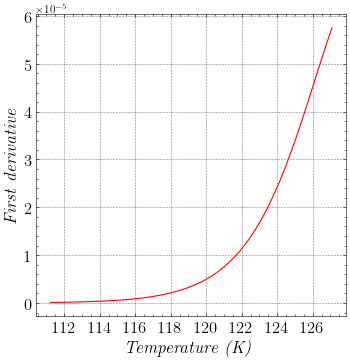

SECOND DERIVATIVE


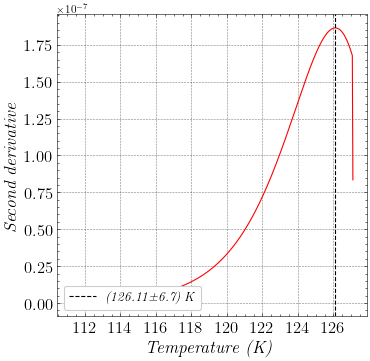

In [277]:
# FITTING OUR FUNCTION
x_min, x_max = 110, 130
df_study = df[(df['Temperature (K)'] >= x_min) & (df['Temperature (K)'] <= x_max)]
xdata, ydata, error_x, error_y = df_study['Temperature (K)'], df_study['Resistance ($\Omega$)'], df_study['$\Delta$ T (K)'], df_study['$\Delta$ R ($\Omega$)']
FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', 'Temperature (K)', 'Resistance ($\Omega$)', Sigmoid)

# WARMING 4

In [354]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_Warming4.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = df['Voltage (mV)']/df['I (mA)']

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,100.067721,0.000580,82.448578,5.797178e-06,0.01,0.01,0.01,0.000094
1,100.070905,0.000874,82.565718,8.734279e-06,0.01,0.01,0.01,0.000091
2,100.070495,0.000094,82.668089,9.360943e-07,0.01,0.01,0.01,0.000099
3,100.077036,0.000580,82.769397,5.796981e-06,0.01,0.01,0.01,0.000094
4,100.073044,0.000703,82.855812,7.025548e-06,0.01,0.01,0.01,0.000093


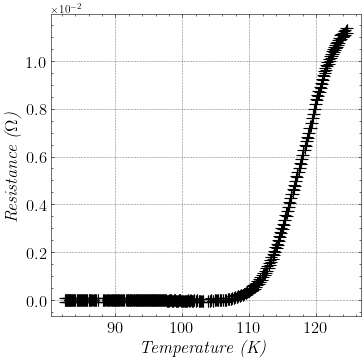

In [355]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')

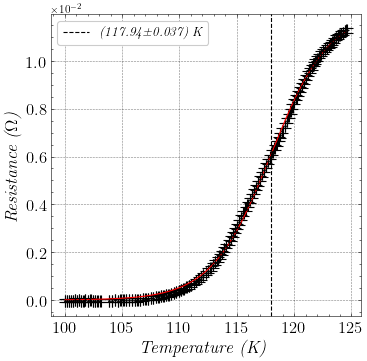

Corresponding p-value: 0.18281397162490542
Degrees of freedom: 122
FIRST DERIVATIVE


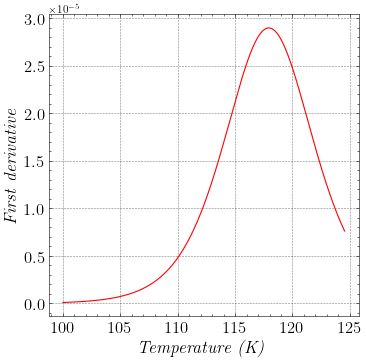

SECOND DERIVATIVE


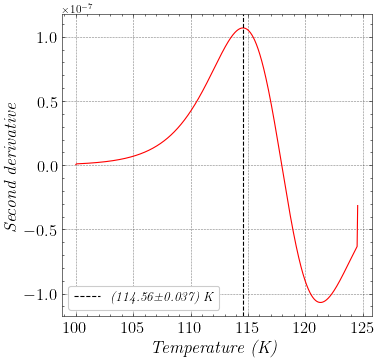

In [356]:
# FITTING OUR FUNCTION
x_min, x_max = 100, 130
df_study = df[(df['Temperature (K)'] >= x_min) & (df['Temperature (K)'] <= x_max)]
xdata, ydata, error_x, error_y = df_study['Temperature (K)'], df_study['Resistance ($\Omega$)'], df_study['$\Delta$ T (K)'], df_study['$\Delta$ R ($\Omega$)']
results, tc_val = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'red', 'Temperature (K)', 'Resistance ($\Omega$)', Sigmoid)
temperatures.append(tc_val)
results

# WEIGHTED AVERAGES

In [287]:
# DEFINING A FUNCTION THAT RETURNS THE WEIGHTED AVERAGE WITH UNCERTAINTY
def weighted_avgs(values, deltas):
    weights = np.array(list(map(lambda x : 1/x**2, deltas)))
    best_val = np.dot(np.array(values), weights)/weights.sum()
    uncert = 1/np.sqrt(weights.sum())
    return [best_val, uncert]

In [341]:
temp = np.array(temperatures)
temp

array([[1.38949389e+02, 1.64051190e-01],
       [1.11926707e+02, 1.81320779e-02],
       [1.34162998e+02, 8.30725880e-01],
       [1.14436872e+02, 6.04419772e-02],
       [1.13991735e+02, 3.18554682e-02],
       [1.14556388e+02, 3.67063740e-02]])

In [343]:
critical_temp = weighted_avgs(temp[:,0], temp[:,1])
critical_temp

[113.05039263606626, 0.014028139037046954]

In [357]:
temp = np.array(temperatures)
temp

array([[1.11926707e+02, 1.81320779e-02],
       [1.14436872e+02, 6.04419772e-02],
       [1.13991735e+02, 3.18554682e-02],
       [1.14556388e+02, 3.67063740e-02]])

In [358]:
critical_temp = weighted_avgs(temp[:,0], temp[:,1])
critical_temp

[112.85350067015618, 0.0140817322021948]

In [365]:
# DETERMING THE %ERROR
t_theor = 108 # K
error = abs((critical_temp[0]-t_theor)/t_theor)*100
print("Percentage error: ", error, "%")
exp_precision = 100*critical_temp[1]/critical_temp[0]
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

Percentage error:  4.493982101996463 %
Experimental precision: 0.012477886922934132 %
Sigmas: 360.15570022009126


***
### <font color=green>BUCKET 2 (NO SUPERCONDUCTOR)</font>
***

In [363]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_NS_Cooling1.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = df['Voltage (mV)']/df['I (mA)']

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,998.941631,306.147303,220.535324,0.306472,0.01,0.01,0.01,0.00001
1,998.939564,306.214225,220.553682,0.306539,0.01,0.01,0.01,0.00001
2,998.815898,306.202823,220.565898,0.306566,0.01,0.01,0.01,0.00001
3,998.775125,306.240828,220.572254,0.306616,0.01,0.01,0.01,0.00001
4,998.837460,306.289571,220.599369,0.306646,0.01,0.01,0.01,0.00001


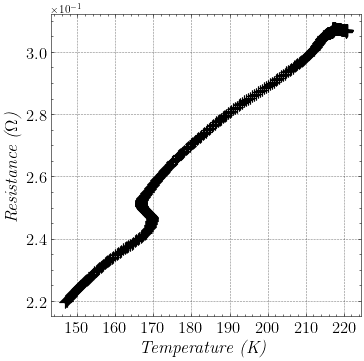

In [364]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')

In [361]:
# READING THE DATA FROM .txt FILES ---------------------------------------
data = CLEAN_INPUT('Week2Files/EvanRenzo_NS_Warming1.txt')
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = df['Voltage (mV)']/df['I (mA)']

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
0,100.085860,189.518018,142.976582,1.893554,0.01,0.01,0.01,0.000214
1,100.106054,189.483372,143.027465,1.892826,0.01,0.01,0.01,0.000214
2,100.102623,189.450898,143.078999,1.892567,0.01,0.01,0.01,0.000214
3,100.106696,189.413104,143.115365,1.892112,0.01,0.01,0.01,0.000214
4,100.094269,189.353296,143.161940,1.891750,0.01,0.01,0.01,0.000214


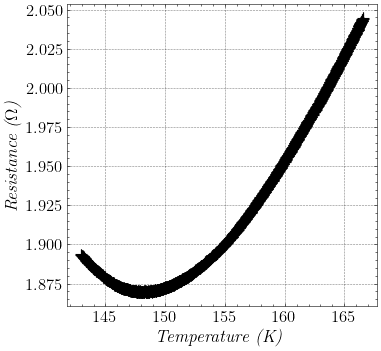

In [362]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']
ScatterPlot(xdata, ydata, error_x, error_y, 'purple', 'Temperature (K)', 'Resistance ($\Omega$)')